#  Gamestock: Robbin' the Hood

In [1]:
import random
import json
import requests
from config import api_key_alpha
from pprint import pprint
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
from sklearn import datasets

## Historical GameStop Stock Analysis

In [2]:
# Query URL for trades in last two months
query_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=GME&interval=60min&outputsize=full&apikey={api_key_alpha}"

In [3]:
# Create DataFrame for hourly trades in last two months
gme_get = requests.get(query_url).json()

GME_df_hourly = pd.DataFrame(gme_get['Time Series (60min)']).T
GME_df_hourly = GME_df_hourly.rename(columns={'1. open': 'Opening Price',
                                '2. high': 'Highest Price',
                                '3. low': 'Lowest Price',
                                '4. close': 'Closing Price',
                                '5. volume': 'Trade Volume'})
GME_df_hourly

,Opening Price,Highest Price,Lowest Price,Closing Price,Trade Volume
2021-03-19 20:00:00,199.9800,199.9900,198.5601,199.0000,20719
2021-03-19 19:00:00,200.2400,200.2900,199.0000,200.0000,35919
2021-03-19 18:00:00,200.0000,200.4000,199.5500,200.2400,46334
2021-03-19 17:00:00,200.2700,201.0000,198.2500,200.4000,333311
2021-03-19 16:00:00,212.2300,212.2300,199.4600,199.4600,2566184
...,...,...,...,...,...
2021-01-25 09:00:00,91.7100,104.5300,86.9999,98.0500,4674120
2021-01-25 08:00:00,94.4800,97.0000,86.7200,91.6500,2187519
2021-01-25 07:00:00,96.9300,101.7000,90.3500,94.4300,784325
2021-01-25 06:00:00,106.7700,109.0000,86.2500,96.7700,885972


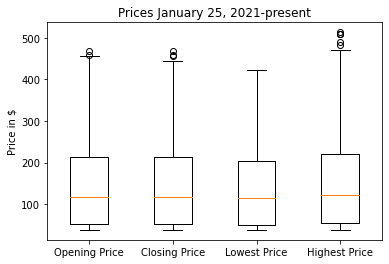

In [4]:
# Create Lists:
opening = GME_df_hourly['Opening Price'].astype(float)
closing = GME_df_hourly['Closing Price'].astype(float)
low = GME_df_hourly['Lowest Price'].astype(float)
high = GME_df_hourly['Highest Price'].astype(float)
volume = GME_df_hourly['Trade Volume'].astype(float)

# Make box plot of prices since 1/25/2021
fig1, ax1 = plt.subplots()
plot_GME = [opening,closing,low,high]
price_labels = ["Opening Price", "Closing Price","Lowest Price","Highest Price"]
ax1.set_title('Prices January 25, 2021-present')
ax1.set_ylabel('Price in $')
ax1.boxplot(plot_GME,labels=price_labels)

plt.show()

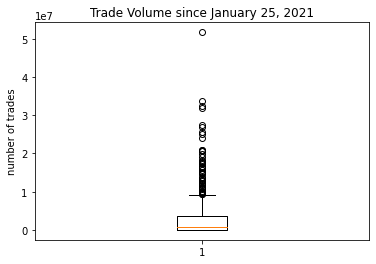

In [5]:
# Make box plot of trade Volume since 1/25/2021
fig1, ax1 = plt.subplots()
ax1.set_title('Trade Volume since January 25, 2021')
ax1.set_ylabel('number of trades')
ax1.boxplot(volume)
plt.show()

In [6]:
# Get daily data set for all time

url_daily = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GME&outputsize=full&apikey={api_key_alpha}"
    
gme_daily = requests.get(url_daily).json()

In [7]:
# Create DataFrame
daily_df = pd.DataFrame(gme_daily['Time Series (Daily)']).T
daily_df = daily_df.rename(columns={'1. open': 'Opening Price Daily',
                                '2. high': 'Highest Price Daily',
                                '3. low': 'Lowest Price Daily',
                                '4. close': 'Closing Price Daily',
                                '5. volume': 'Trade Volume Daily'})
daily_df

,Opening Price Daily,Highest Price Daily,Lowest Price Daily,Closing Price Daily,Trade Volume Daily
2021-03-22,205.2600,210.3562,186.1952,194.4900,9600874
2021-03-19,195.7300,227.0000,182.6600,200.2700,24677297
2021-03-18,214.0000,218.8800,195.6500,201.7500,11799914
2021-03-17,217.8400,231.4700,204.0000,209.8100,16481589
2021-03-16,203.1600,220.7000,172.3500,208.1700,35422867
...,...,...,...,...,...
2002-02-20,19.7500,19.7500,19.0500,19.7500,861600
2002-02-19,19.8000,19.8000,18.7500,19.1000,926300
2002-02-15,20.0500,20.0500,19.7000,19.9000,1048700
2002-02-14,20.3500,20.3900,19.8500,20.0000,1377700


In [8]:
# We will be analyzing highest price and volume
# Create Lists:
opening_daily = daily_df['Opening Price Daily'].astype(float)
closing_daily = daily_df['Closing Price Daily'].astype(float)
low_daily = daily_df['Lowest Price Daily'].astype(float)
high_daily = daily_df['Highest Price Daily'].astype(float)
volume_daily = daily_df['Trade Volume Daily'].astype(float)

#Find Quartiles:
#Find quartiles of Highest Price
quartiles = high_daily.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
price_lower_bound = lowerq - (1.5*iqr)
price_upper_bound = upperq + (1.5*iqr)
print("Highest Price Quartiles:")
print(f"The lower quartile: {lowerq}")
print(f"The upper quartile: {upperq}")
print(f"The interquartile range: {iqr}")
print(f"The median: {quartiles[0.5]} ")
print(f"Values below {round(price_lower_bound, 6)} could be outliers.")
print(f"Values above {round(price_upper_bound, 6)} could be outliers.")  
print("-----------------------------------------")

#Find quartiles of Volume
quartiles = volume.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
volume_lower_bound = lowerq - (1.5*iqr)
volume_upper_bound = upperq + (1.5*iqr)
print("Trade Volume Quartiles:")
print(f"The lower quartile: {lowerq}")
print(f"The upper quartile: {upperq}")
print(f"The interquartile range: {iqr}")
print(f"The median: {quartiles[0.5]} ")
print(f"Values below {round(volume_lower_bound, 6)} could be outliers.")
print(f"Values above {round(volume_upper_bound, 6)} could be outliers.")

Highest Price Quartiles:
The lower quartile: 18.12
The upper quartile: 37.89
The interquartile range: 19.77
The median: 23.97 
Values below -11.535 could be outliers.
Values above 67.545 could be outliers.
-----------------------------------------
Trade Volume Quartiles:
The lower quartile: 89344.25
The upper quartile: 3744178.75
The interquartile range: 3654834.5
The median: 844460.0 
Values below -5392907.5 could be outliers.
Values above 9226430.5 could be outliers.


In [9]:
# Since it is not possible for a stock price to go below $0
# or for Volume to be below zero, we only need to look at the upperbound
price_outliers = []

# Create DataFrame of outliers for highest price
for price in high:
    if price > price_upper_bound:
        price_outliers.append(daily_df['Highest Price Daily'])

In [10]:
outliers_df = pd.DataFrame(price_outliers).T

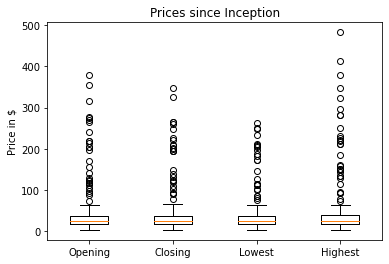

In [11]:
# Make box plot of prices since inception
fig1, ax1 = plt.subplots()
plot_GME = [opening_daily,closing_daily,low_daily,high_daily]
price_labels = ["Opening", "Closing","Lowest","Highest"]
ax1.set_title('Prices since Inception')
ax1.set_ylabel('Price in $')
ax1.boxplot(plot_GME,labels=price_labels)

plt.show()

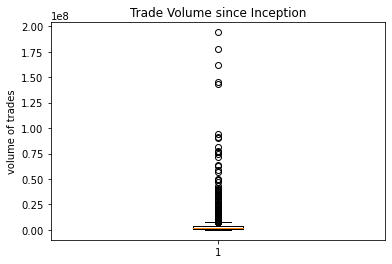

In [12]:
# Make box plot of trade volume since inception
fig1, ax1 = plt.subplots()
ax1.set_title('Trade Volume since Inception')
ax1.set_ylabel('number of trades')
ax1.set_ylabel('volume of trades')
ax1.boxplot(volume_daily)
plt.show()

## Comparison to other Stocks in 2021

In [21]:
# Get daily data set AMC
url_amc = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AMC&outputsize=full&apikey={api_key_alpha}"
amc_daily = requests.get(url_amc).json()

In [22]:
AMC_df = pd.DataFrame(amc_daily['Time Series (Daily)']).T
AMC_df = AMC_df.rename(columns={'1. open': 'Opening Price Daily for AMC',
                                '2. high': 'Highest Price Daily for AMC',
                                '3. low': 'Lowest Price Daily for AMC',
                                '4. close': 'Closing Price Daily for AMC',
                                '5. volume': 'Trade Volume Daily for AMC'})
AMC_df

,Opening Price Daily for AMC,Highest Price Daily for AMC,Lowest Price Daily for AMC,Closing Price Daily for AMC,Trade Volume Daily for AMC
2021-03-22,13.1500,13.1900,11.7600,12.4900,88760137
2021-03-19,14.1400,14.1800,13.2800,13.9300,153205985
2021-03-18,14.3400,14.5400,13.5700,14.0000,122212275
2021-03-17,13.2400,13.6600,13.0000,13.5600,78053640
2021-03-16,13.6200,13.6200,12.3400,13.0200,125967622
...,...,...,...,...,...
2013-12-24,19.7400,19.8200,19.5000,19.5300,213700
2013-12-23,19.7900,19.9900,19.5000,19.7400,698100
2013-12-20,19.6500,19.7700,19.4000,19.6800,737100
2013-12-19,18.9000,19.4900,18.8100,19.4900,1605400


In [23]:
# Create Lists:
opening_amc = AMC_df['Opening Price Daily for AMC'].astype(float)
closing_amc = AMC_df['Closing Price Daily for AMC'].astype(float)
low_amc = AMC_df['Lowest Price Daily for AMC'].astype(float)
high_amc = AMC_df['Closing Price Daily for AMC'].astype(float)
volume_amc = AMC_df['Trade Volume Daily for AMC'].astype(float)

In [24]:
# Get daily data set BBY
url_bby = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=BBY&outputsize=full&apikey={api_key_alpha}"
bby_daily = requests.get(url_bby).json()

In [25]:
bby_df = pd.DataFrame(bby_daily['Time Series (Daily)']).T
bby_df = bby_df.rename(columns={'1. open': 'Opening Price Daily for Best Buy',
                                '2. high': 'Highest Price Daily for Best Buy',
                                '3. low': 'Lowest Price Daily for Best Buy',
                                '4. close': 'Closing Price Daily for Best Buy',
                                '5. volume': 'Trade Volume Daily for Best Buy'})
bby_df

,Opening Price Daily for Best Buy,Highest Price Daily for Best Buy,Lowest Price Daily for Best Buy,Closing Price Daily for Best Buy,Trade Volume Daily for Best Buy
2021-03-22,118.1000,121.2850,117.1100,120.9600,2809867
2021-03-19,113.8300,120.2900,113.6768,118.1900,9098446
2021-03-18,111.6100,116.2600,111.3100,113.3800,2906572
2021-03-17,112.1600,112.8500,109.9800,112.2500,2584396
2021-03-16,113.6600,114.4600,112.7000,113.4500,2328194
...,...,...,...,...,...
1999-11-05,54.2500,54.5000,50.0000,50.6300,3824000
1999-11-04,53.9400,54.3100,51.6900,52.0000,2052444
1999-11-03,51.9400,53.3100,51.0000,51.6300,2474978
1999-11-02,51.6300,53.8100,50.1900,50.8800,4395600


In [26]:
#Create Lists:
opening_bby = bby_df['Opening Price Daily for Best Buy'].astype(float)
closing_bby = bby_df['Closing Price Daily for Best Buy'].astype(float)
low_bby = bby_df['Lowest Price Daily for Best Buy'].astype(float)
high_bby = bby_df['Closing Price Daily for Best Buy'].astype(float)
volume_bby = bby_df['Trade Volume Daily for Best Buy'].astype(float)

In [29]:
amc_21_flip = AMC_df[:55]
amc_21 = amc_21_flip.iloc[::-1]
date_amc = amc_21.index
high_amc = amc_21['Highest Price Daily for AMC'].astype(float)

gme_21_flip = daily_df[:55]
gme_21 = gme_21_flip.iloc[::-1]
date_gme = gme_21.index
high_gme = gme_21['Highest Price Daily'].astype(float)

bby_21_flip = bby_df[:55]
bby_21 = bby_21_flip.iloc[::-1]
date_bby = bby_21.index
high_bby = bby_21['Highest Price Daily for Best Buy'].astype(float)

<function matplotlib.pyplot.show(close=None, block=None)>

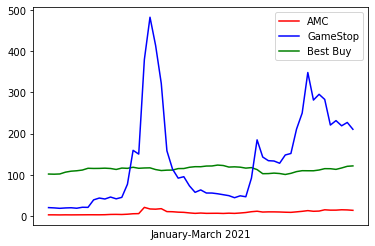

In [30]:
# Create a legend for our chart
bby_plot, = plt.plot(date_bby, high_bby,color="green", label="Best Buy")
gme_plot, = plt.plot(date_gme, high_gme,color="blue",label="GameStop")
amc_plot, = plt.plot(date_amc, high_amc,color="red", label="AMC")

plt.legend(handles=[amc_plot, gme_plot, bby_plot])
plt.xticks([])
plt.xlabel("January-March 2021")

plt.show

## Correlation between Wallstreetbets Subreddit Posts and GME Trade Volume

In [13]:
# Import CSV with Daily WSB Subreddit posts
daily_wsb = "Resources/daily_reddit.csv"
daily_wsb_df = pd.read_csv("Resources/daily_reddit.csv")
daily_wsb_df

,Date,Count
0,28-Jan,1197
1,29-Jan,15694
2,30-Jan,1423
3,31-Jan,939
4,1-Feb,884
5,2-Feb,1502
6,3-Feb,2643
7,4-Feb,1671
8,5-Feb,2598
9,6-Feb,2791


In [16]:
# Create new DataFrame for daily GME data over same time period as WSB data 
corresponding_gme = daily_df.iloc[6:37, :]
corresponding_daily_gme = corresponding_gme.iloc[::-1]
corresponding_daily_gme

,Opening Price Daily,Highest Price Daily,Lowest Price Daily,Closing Price Daily,Trade Volume Daily
2021-01-28,265.0000,483.0000,112.2500,193.6000,58815805
2021-01-29,379.7100,413.9800,250.0000,325.0000,49414294
2021-02-01,316.5600,322.0000,212.0000,225.0000,37382152
2021-02-02,140.7600,158.0000,74.2201,90.0000,76663691
2021-02-03,112.0100,113.3999,85.2500,92.4100,42698511
2021-02-04,91.1900,91.5000,53.3300,53.5000,62427275
2021-02-05,54.0400,95.0000,51.0900,63.7700,81345013
2021-02-08,72.4100,72.6600,58.0200,60.0000,25687282
2021-02-09,56.6100,57.0000,46.5200,50.3100,25598598
2021-02-10,50.7700,62.8300,46.5500,51.2000,35943280


In [17]:
# Eliminate days from Subreddit data when market was not open
daily_wsb_market_open = daily_wsb_df.drop(labels=[2,3,9,10,16,17,18, 23,24,30,31,37,38], axis=0)
daily_wsb_market_open

,Date,Count
0,28-Jan,1197
1,29-Jan,15694
4,1-Feb,884
5,2-Feb,1502
6,3-Feb,2643
7,4-Feb,1671
8,5-Feb,2598
11,8-Feb,287
12,9-Feb,148
13,10-Feb,222


The r-squared value is: 0.14


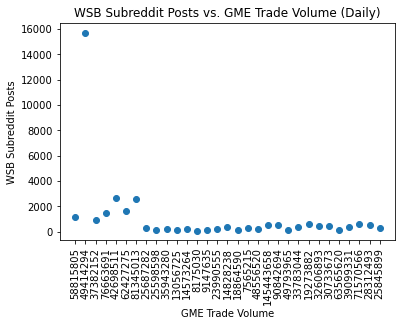

In [18]:
# Scatter plot and r-squared value

# Define x values and y values
x_values = corresponding_daily_gme["Trade Volume Daily"].values.astype(float)
y_values = daily_wsb_market_open["Count"].values.astype(float)

# Calculate r-squared value
correlation = st.pearsonr(x_values, y_values)
print(f"The r-squared value is: {round(correlation[0],2)}")

# Create scatter plot
plt.scatter(corresponding_daily_gme["Trade Volume Daily"].values, daily_wsb_market_open["Count"].values)

# Label title and axes
plt.title("WSB Subreddit Posts vs. GME Trade Volume (Daily)")
plt.xlabel("GME Trade Volume")
plt.ylabel("WSB Subreddit Posts")
plt.xticks(rotation=90)

# Show plot
plt.show()

In [19]:
# Remove outliers from DataFrame (days with >1000 Subreddit posts)

gme_daily_no_outliers = corresponding_daily_gme.iloc[7:31]

wsb_daily_no_outliers = daily_wsb_market_open.drop(labels=[0, 1, 4, 5, 6, 7, 8], axis=0)

The r-squared value is: 0.47


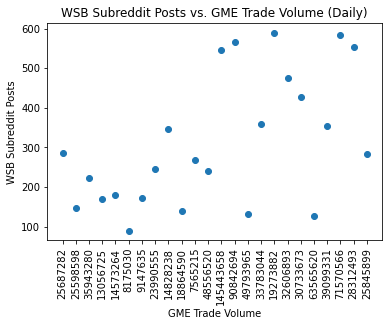

In [20]:
# Scatter plot and r-squared value

# Define x values and y values
x_values = gme_daily_no_outliers["Trade Volume Daily"].values.astype(float)
y_values = wsb_daily_no_outliers["Count"].values.astype(float)

# Calculate r-squared value
correlation = st.pearsonr(x_values, y_values)
print(f"The r-squared value is: {round(correlation[0],2)}")

# Create scatter plot
plt.scatter(gme_daily_no_outliers["Trade Volume Daily"].values, wsb_daily_no_outliers["Count"].values)

# Label title and axes
plt.title("WSB Subreddit Posts vs. GME Trade Volume (Daily)")
plt.xlabel("GME Trade Volume")
plt.ylabel("WSB Subreddit Posts")
plt.xticks(rotation=90)

# Show plot
plt.show()

There is a very weak positive correlation between Wall Street Bets Subreddit posts and GME trade volume in our initial plot (r-squared value of 0.14). However, after removing outliers, days with over 1,000 Subreddit posts, we found that there is a moderate positive correlation between Wall Street Bets Subreddit posts and GME trade volume (r-squared value of 0.47).